In [1]:
# --- Standard libraries
import os.path as osp
import pandas as pd
import numpy as np
import pickle as pkl
# --- Matplotlib
import matplotlib.pyplot as plt
#import imageio
import torch
import torch_geometric
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
# --- XASNet
from XASNet.data import QM9_XAS
from XASNet.data import save_split
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.trainer import GNNTrainer
from dataset import XASMolDataset

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

Pytorch version: 2.4.1+cu121
PyG version: 2.5.3


In [3]:
path = '../'
dataset = XASMolDataset(path)

# go_spec = torch.load('./processed/cor_xasnet.pt')

/home/samjhall/miniconda3/envs/xasnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and to

In [4]:
# --- Print details of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print('')

# --- Print details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASMolDataset(317)
------------
Number of graphs: 317
Number of features: 15

Data(x=[27, 15], edge_index=[2, 72], edge_attr=[72, 5], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')
------------
Number of nodes: 27
Number of edges: 72
Average node degree: 2.67
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [5]:
# --- Create spilt file with the dataset
# --- split into test, validation and test datasets
data_seed = 256

idxs = save_split(
    path='../processed/xasnet_split_sd' + str(data_seed) + '.npz',
    ndata=len(dataset),
    ntrain=238, # 75% split
    nval=40, # 12.5% split
    ntest=39, # 12.5% split
    save_split=True,
    shuffle=True,
    seed=data_seed, 
    print_nsample=True
)

In [6]:
# --- Create variables for each dataset split
train_go = [dataset[i] for i in idxs['train']]
val_go = [dataset[i] for i in idxs['val']]

# --- Save datasets splits into dataloaders
train_loader = DataLoader(train_go, batch_size=32, shuffle=True)
val_loader = DataLoader(val_go, batch_size=32, shuffle=True)

print(f'Training dataset length: {len(train_go)}, compiled in {len(train_loader)} loaders')
print(f'Validation dataset length: {len(val_go)}, compiled in {len(val_loader)} loaders')

Training dataset length: 238, compiled in 8 loaders
Validation dataset length: 40, compiled in 2 loaders


In [7]:
# --- Define cost functions
def RSE_loss(prediction, target):
    dE = (300 - 280) / 200
    nom = torch.sum(dE*torch.pow((target-prediction), 2))
    denom = torch.sum(dE*target)
    return torch.sqrt(nom) / denom 

def RMSE_loss(prediction, target):
    return torch.sqrt(torch.mean((target - prediction)**2))

In [8]:
# --- Set number of epochs to run
num_epochs = 300
# --- Set the learning rate 
lr = 0.01
# --- Milestones to reduce learning rate in steps 
milestones = np.arange(200, 900, 200).tolist()
print(milestones)

[200, 400, 600, 800]


##### XASNet GNN

In [9]:
# --- Set a manual seed for reproducibility
seed = 1994
torch.manual_seed(seed)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [15, 64, 128], # input nodes for each layer
    out_channels = [64, 128, 256], # output nodes for each layer
    num_targets = 200, # nodes for final output
    num_layers = 3, # number of total layers
    dropout = 0.1,
    heads = 0
).to(device)

# --- Set model name
model_name = xasnet_gnn.gnn_name +'_model_sd' + str(seed)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [10]:
# --- View the details of the created model
print(xasnet_gnn)
print('----')
print(f' Model will be trained on: {device} - {torch.cuda.get_device_name(0)}')

XASNet_GNN(
  (interaction_layers): ModuleList(
    (0): GCNConv(15, 64)
    (1): ReLU(inplace=True)
    (2): GCNConv(64, 128)
    (3): ReLU(inplace=True)
    (4): GCNConv(128, 256)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=256, out_features=200, bias=True)
)
----
 Model will be trained on: cuda - NVIDIA GeForce RTX 4080


##### XASNet GAT

In [11]:
# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=8,
    in_channels=[64, 128],
    out_channels=[128, 256],
    targets=200,
    n_layers=2,
    n_heads=4,
    gat_type='gatv2',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Set name for ML model
model_name = 'xasnet-GAT_' + xasnet_gat.gat_type + '_model'

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

TypeError: XASNet_GAT.__init__() missing 1 required positional argument: 'dropout'

In [ ]:
# --- View the details of the created model
print(xasnet_gat)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=8, out_features=64, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (3): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATv2Conv(64, 128, heads=4)
    (1): ReLU(inplace=True)
    (2): GATv2Conv(512, 256, heads=1)
  )
  (lstm): LSTM(512, 128, num_layers=3, batch_first=True, bidirectional=

##### XASNet GraphNet

In [ ]:
# --- Set name for ML model
model_name = 'xasnet_graphnet_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=8,
    edge_dim=5,
    hidden_channels=64,
    out_channels=128,
    gat_hidd=64,
    gat_out=128,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [ ]:
# --- View the details of the created model
print(xasnet_graphnet)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(8, 64, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(192, 64, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(192, 64, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(192, 128, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=146, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=389, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
         

##### Train model

In [11]:
chosen_model = xasnet_gnn

In [12]:
# --- Set additional ML parameters
optimizer = torch.optim.Adam(chosen_model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.99), eps=1e-08, amsgrad=True)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [13]:
# --- Create trainier
trainer = GNNTrainer(model = chosen_model,
                     model_name = model_name,
                     device = device,
                     metric_path = './metrics/' + model_name)

#### Train the ML model        

In [14]:
trainer.train_val(train_loader, val_loader, optimizer, MSELoss(), #RSE_loss,
                  scheduler, num_epochs, write_every=2, train_graphnet=False)

  1%|▏         | 4/300 [00:00<00:22, 12.99it/s]

time = 0.00 mins mins
epoch 0 | average train loss = 0.00325 and average validation loss = 0.00077 | learning rate = 0.01000
time = 0.00 mins mins
epoch 2 | average train loss = 0.00053 and average validation loss = 0.00067 | learning rate = 0.01000
time = 0.01 mins mins
epoch 4 | average train loss = 0.00048 and average validation loss = 0.00065 | learning rate = 0.01000


  3%|▎         | 10/300 [00:00<00:15, 18.54it/s]

time = 0.01 mins mins
epoch 6 | average train loss = 0.00041 and average validation loss = 0.00061 | learning rate = 0.01000
time = 0.01 mins mins
epoch 8 | average train loss = 0.00039 and average validation loss = 0.00066 | learning rate = 0.01000
time = 0.01 mins mins
epoch 10 | average train loss = 0.00038 and average validation loss = 0.00069 | learning rate = 0.01000


  5%|▌         | 16/300 [00:00<00:13, 21.13it/s]

time = 0.01 mins mins
epoch 12 | average train loss = 0.00038 and average validation loss = 0.00055 | learning rate = 0.01000
time = 0.01 mins mins
epoch 14 | average train loss = 0.00036 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.01 mins mins
epoch 16 | average train loss = 0.00033 and average validation loss = 0.00046 | learning rate = 0.01000


  6%|▋         | 19/300 [00:01<00:12, 21.62it/s]

time = 0.02 mins mins
epoch 18 | average train loss = 0.00034 and average validation loss = 0.00051 | learning rate = 0.01000
time = 0.02 mins mins
epoch 20 | average train loss = 0.00033 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.02 mins mins
epoch 22 | average train loss = 0.00032 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.02 mins mins
epoch 24 | average train loss = 0.00032 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.02 mins mins
epoch 26 | average train loss = 0.00031 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.02 mins mins
epoch 28 | average train loss = 0.00033 and average validation loss = 0.00054 | learning rate = 0.01000
time = 0.02 mins mins
epoch 30 | average train loss = 0.00030 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.02 mins mins
epoch 32 | average train loss = 0.00030 and average validation loss = 0.00049 | learning rate = 

 27%|██▋       | 80/300 [00:01<00:01, 171.31it/s]

time = 0.05 mins mins
epoch 78 | average train loss = 0.00027 and average validation loss = 0.00037 | learning rate = 0.01000
time = 0.06 mins mins
epoch 80 | average train loss = 0.00027 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.06 mins mins
epoch 82 | average train loss = 0.00027 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.06 mins mins
epoch 84 | average train loss = 0.00027 and average validation loss = 0.00055 | learning rate = 0.01000
time = 0.06 mins mins
epoch 86 | average train loss = 0.00026 and average validation loss = 0.00036 | learning rate = 0.01000
time = 0.06 mins mins
epoch 88 | average train loss = 0.00028 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.06 mins mins
epoch 90 | average train loss = 0.00029 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.06 mins mins
epoch 92 | average train loss = 0.00026 and average validation loss = 0.00038 | learning rate = 

 34%|███▎      | 101/300 [00:02<00:03, 57.06it/s]

time = 0.07 mins mins
epoch 96 | average train loss = 0.00029 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.07 mins mins
epoch 98 | average train loss = 0.00027 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.07 mins mins
epoch 100 | average train loss = 0.00026 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.07 mins mins
epoch 102 | average train loss = 0.00027 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.07 mins mins
epoch 104 | average train loss = 0.00028 and average validation loss = 0.00039 | learning rate = 0.01000
time = 0.07 mins mins
epoch 106 | average train loss = 0.00030 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.07 mins mins
epoch 108 | average train loss = 0.00027 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.08 mins mins
epoch 110 | average train loss = 0.00026 and average validation loss = 0.00043 | learning r

 39%|███▊      | 116/300 [00:02<00:04, 41.92it/s]

time = 0.08 mins mins
epoch 114 | average train loss = 0.00025 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.08 mins mins
epoch 116 | average train loss = 0.00026 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.08 mins mins
epoch 118 | average train loss = 0.00026 and average validation loss = 0.00036 | learning rate = 0.01000
time = 0.08 mins mins
epoch 120 | average train loss = 0.00025 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.08 mins mins
epoch 122 | average train loss = 0.00025 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.09 mins mins
epoch 124 | average train loss = 0.00029 and average validation loss = 0.00054 | learning rate = 0.01000


 42%|████▏     | 127/300 [00:03<00:04, 35.35it/s]

time = 0.09 mins mins
epoch 126 | average train loss = 0.00029 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.09 mins mins
epoch 128 | average train loss = 0.00028 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.09 mins mins
epoch 130 | average train loss = 0.00027 and average validation loss = 0.00044 | learning rate = 0.01000


 45%|████▌     | 136/300 [00:03<00:05, 31.56it/s]

time = 0.09 mins mins
epoch 132 | average train loss = 0.00027 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.09 mins mins
epoch 134 | average train loss = 0.00026 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.09 mins mins
epoch 136 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000


 48%|████▊     | 143/300 [00:03<00:05, 29.46it/s]

time = 0.10 mins mins
epoch 138 | average train loss = 0.00025 and average validation loss = 0.00039 | learning rate = 0.01000
time = 0.10 mins mins
epoch 140 | average train loss = 0.00027 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.10 mins mins
epoch 142 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000


 50%|████▉     | 149/300 [00:04<00:05, 27.77it/s]

time = 0.10 mins mins
epoch 144 | average train loss = 0.00025 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.10 mins mins
epoch 146 | average train loss = 0.00026 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.10 mins mins
epoch 148 | average train loss = 0.00026 and average validation loss = 0.00040 | learning rate = 0.01000


 51%|█████▏    | 154/300 [00:04<00:05, 26.92it/s]

time = 0.10 mins mins
epoch 150 | average train loss = 0.00025 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.11 mins mins
epoch 152 | average train loss = 0.00026 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.11 mins mins
epoch 154 | average train loss = 0.00024 and average validation loss = 0.00048 | learning rate = 0.01000


 53%|█████▎    | 158/300 [00:04<00:05, 26.28it/s]

time = 0.11 mins mins
epoch 156 | average train loss = 0.00026 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.11 mins mins
epoch 158 | average train loss = 0.00027 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.11 mins mins
epoch 160 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000


 55%|█████▌    | 165/300 [00:04<00:05, 25.22it/s]

time = 0.11 mins mins
epoch 162 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.11 mins mins
epoch 164 | average train loss = 0.00026 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.11 mins mins
epoch 166 | average train loss = 0.00026 and average validation loss = 0.00044 | learning rate = 0.01000


 57%|█████▋    | 171/300 [00:05<00:05, 23.91it/s]

time = 0.12 mins mins
epoch 168 | average train loss = 0.00025 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.12 mins mins
epoch 170 | average train loss = 0.00024 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.12 mins mins
epoch 172 | average train loss = 0.00025 and average validation loss = 0.00045 | learning rate = 0.01000


 59%|█████▉    | 177/300 [00:05<00:05, 23.53it/s]

time = 0.12 mins mins
epoch 174 | average train loss = 0.00027 and average validation loss = 0.00050 | learning rate = 0.01000
time = 0.12 mins mins
epoch 176 | average train loss = 0.00026 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.12 mins mins
epoch 178 | average train loss = 0.00025 and average validation loss = 0.00042 | learning rate = 0.01000


 61%|██████    | 183/300 [00:05<00:05, 23.40it/s]

time = 0.12 mins mins
epoch 180 | average train loss = 0.00025 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.13 mins mins
epoch 182 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000
time = 0.13 mins mins
epoch 184 | average train loss = 0.00026 and average validation loss = 0.00039 | learning rate = 0.01000


 63%|██████▎   | 189/300 [00:05<00:04, 23.67it/s]

time = 0.13 mins mins
epoch 186 | average train loss = 0.00026 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.13 mins mins
epoch 188 | average train loss = 0.00026 and average validation loss = 0.00039 | learning rate = 0.01000
time = 0.13 mins mins
epoch 190 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000


 65%|██████▌   | 195/300 [00:06<00:04, 22.86it/s]

time = 0.13 mins mins
epoch 192 | average train loss = 0.00024 and average validation loss = 0.00037 | learning rate = 0.01000
time = 0.13 mins mins
epoch 194 | average train loss = 0.00026 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.14 mins mins
epoch 196 | average train loss = 0.00026 and average validation loss = 0.00039 | learning rate = 0.01000


 67%|██████▋   | 201/300 [00:06<00:04, 22.52it/s]

time = 0.14 mins mins
epoch 198 | average train loss = 0.00025 and average validation loss = 0.00035 | learning rate = 0.01000
time = 0.14 mins mins
epoch 200 | average train loss = 0.00025 and average validation loss = 0.00048 | learning rate = 0.01000
time = 0.14 mins mins
epoch 202 | average train loss = 0.00026 and average validation loss = 0.00039 | learning rate = 0.01000


 70%|███████   | 210/300 [00:06<00:03, 24.87it/s]

time = 0.14 mins mins
epoch 204 | average train loss = 0.00025 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.14 mins mins
epoch 206 | average train loss = 0.00024 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.14 mins mins
epoch 208 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000


 72%|███████▏  | 216/300 [00:07<00:03, 25.68it/s]

time = 0.14 mins mins
epoch 210 | average train loss = 0.00024 and average validation loss = 0.00048 | learning rate = 0.01000
time = 0.14 mins mins
epoch 212 | average train loss = 0.00025 and average validation loss = 0.00047 | learning rate = 0.01000
time = 0.15 mins mins
epoch 214 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000


 74%|███████▍  | 222/300 [00:07<00:02, 26.34it/s]

time = 0.15 mins mins
epoch 216 | average train loss = 0.00025 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.15 mins mins
epoch 218 | average train loss = 0.00025 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.15 mins mins
epoch 220 | average train loss = 0.00024 and average validation loss = 0.00039 | learning rate = 0.01000


 76%|███████▌  | 228/300 [00:07<00:02, 25.65it/s]

time = 0.15 mins mins
epoch 222 | average train loss = 0.00025 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.15 mins mins
epoch 224 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000
time = 0.15 mins mins
epoch 226 | average train loss = 0.00027 and average validation loss = 0.00040 | learning rate = 0.01000


 78%|███████▊  | 234/300 [00:07<00:02, 25.02it/s]

time = 0.15 mins mins
epoch 228 | average train loss = 0.00026 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.16 mins mins
epoch 230 | average train loss = 0.00030 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.16 mins mins
epoch 232 | average train loss = 0.00026 and average validation loss = 0.00050 | learning rate = 0.01000


 79%|███████▉  | 237/300 [00:07<00:02, 24.48it/s]

time = 0.16 mins mins
epoch 234 | average train loss = 0.00026 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.16 mins mins
epoch 236 | average train loss = 0.00026 and average validation loss = 0.00036 | learning rate = 0.01000
time = 0.16 mins mins
epoch 238 | average train loss = 0.00026 and average validation loss = 0.00041 | learning rate = 0.01000


 81%|████████  | 243/300 [00:08<00:02, 24.60it/s]

time = 0.16 mins mins
epoch 240 | average train loss = 0.00027 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.16 mins mins
epoch 242 | average train loss = 0.00027 and average validation loss = 0.00040 | learning rate = 0.01000
time = 0.16 mins mins
epoch 244 | average train loss = 0.00025 and average validation loss = 0.00039 | learning rate = 0.01000


 84%|████████▍ | 252/300 [00:08<00:01, 24.74it/s]

time = 0.17 mins mins
epoch 246 | average train loss = 0.00025 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.17 mins mins
epoch 248 | average train loss = 0.00025 and average validation loss = 0.00039 | learning rate = 0.01000
time = 0.17 mins mins
epoch 250 | average train loss = 0.00025 and average validation loss = 0.00038 | learning rate = 0.01000


 85%|████████▌ | 255/300 [00:08<00:01, 25.09it/s]

time = 0.17 mins mins
epoch 252 | average train loss = 0.00025 and average validation loss = 0.00048 | learning rate = 0.01000
time = 0.17 mins mins
epoch 254 | average train loss = 0.00025 and average validation loss = 0.00037 | learning rate = 0.01000
time = 0.17 mins mins
epoch 256 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000


 88%|████████▊ | 264/300 [00:08<00:01, 25.19it/s]

time = 0.17 mins mins
epoch 258 | average train loss = 0.00024 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.17 mins mins
epoch 260 | average train loss = 0.00024 and average validation loss = 0.00044 | learning rate = 0.01000
time = 0.18 mins mins
epoch 262 | average train loss = 0.00025 and average validation loss = 0.00040 | learning rate = 0.01000


 90%|█████████ | 270/300 [00:09<00:01, 25.07it/s]

time = 0.18 mins mins
epoch 264 | average train loss = 0.00024 and average validation loss = 0.00046 | learning rate = 0.01000
time = 0.18 mins mins
epoch 266 | average train loss = 0.00025 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.18 mins mins
epoch 268 | average train loss = 0.00025 and average validation loss = 0.00039 | learning rate = 0.01000


 92%|█████████▏| 276/300 [00:09<00:00, 24.82it/s]

time = 0.18 mins mins
epoch 270 | average train loss = 0.00025 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.18 mins mins
epoch 272 | average train loss = 0.00025 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.18 mins mins
epoch 274 | average train loss = 0.00024 and average validation loss = 0.00038 | learning rate = 0.01000


 94%|█████████▍| 282/300 [00:09<00:00, 25.82it/s]

time = 0.18 mins mins
epoch 276 | average train loss = 0.00024 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.19 mins mins
epoch 278 | average train loss = 0.00024 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.19 mins mins
epoch 280 | average train loss = 0.00025 and average validation loss = 0.00036 | learning rate = 0.01000


 96%|█████████▌| 288/300 [00:09<00:00, 26.49it/s]

time = 0.19 mins mins
epoch 282 | average train loss = 0.00025 and average validation loss = 0.00045 | learning rate = 0.01000
time = 0.19 mins mins
epoch 284 | average train loss = 0.00025 and average validation loss = 0.00041 | learning rate = 0.01000
time = 0.19 mins mins
epoch 286 | average train loss = 0.00024 and average validation loss = 0.00042 | learning rate = 0.01000


 98%|█████████▊| 294/300 [00:10<00:00, 26.74it/s]

time = 0.19 mins mins
epoch 288 | average train loss = 0.00024 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.19 mins mins
epoch 290 | average train loss = 0.00024 and average validation loss = 0.00042 | learning rate = 0.01000
time = 0.19 mins mins
epoch 292 | average train loss = 0.00025 and average validation loss = 0.00036 | learning rate = 0.01000


100%|██████████| 300/300 [00:10<00:00, 28.98it/s]

time = 0.19 mins mins
epoch 294 | average train loss = 0.00024 and average validation loss = 0.00043 | learning rate = 0.01000
time = 0.20 mins mins
epoch 296 | average train loss = 0.00025 and average validation loss = 0.00038 | learning rate = 0.01000
time = 0.20 mins mins
epoch 298 | average train loss = 0.00024 and average validation loss = 0.00039 | learning rate = 0.01000


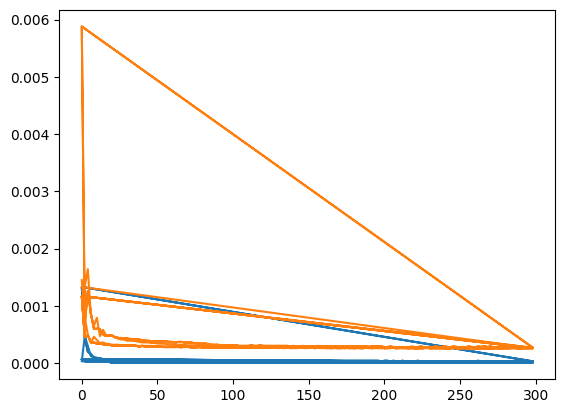

In [ ]:
df_train = pd.read_csv('./metrics/' + model_name + '/train_metrics.csv')
df_val = pd.read_csv('./metrics/' + model_name + '/val_metrics.csv')
plt.plot(df_train['epoch'], df_train['loss'])
plt.plot(df_val['epoch'], df_val['loss'])
plt.show()